# TEST A/B
# Tienda en línea

1. INTRODUCCIÓN 

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

1.1 DESCRIPCIÓN TÉCNICA 

- Nombre de la prueba: recommender_system_test
- Grupos: А (control), B (nuevo embudo de pago)
- Fecha de lanzamiento: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_cart) y compras (purchase). En cada etapa del embudo product_page → product_cart → purchase, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

2. DESCRIPCIÓN DE LOS DATOS 

*ab_project_marketing_events_us.csv* >  el calendario de eventos de marketing para 2020

- 'name': el nombre del evento de marketing
- 'regions': regiones donde se llevará a cabo la campaña publicitaria
- 'start_dt': fecha de inicio de la campaña
- 'finish_dt': fecha de finalización de la campaña

*final_ab_new_users_upd_us.csv* > todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020

- 'user_id'
- 'first_date': fecha de inscripción
- 'region'
- 'device': dispositivo utilizado para la inscripción

*final_ab_events_upd_us.csv* > todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021

- 'user_id'
- 'event_dt':fecha y hora del evento
- 'event_name': nombre del tipo de evento
- 'details': datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos purchase)

*final_ab_participants_upd_us.csv* > tabla con los datos de los participantes de la prueba

- 'user_id'
- 'ab_test': nombre de la prueba
- 'group': el grupo de prueba al que pertenecía el usuario

3. INICIALIZACIÓN

In [35]:
# Se cargan todas las librerias necesarias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

In [36]:
# Se cargan los archivos de datos en DataFrame
marketing_df = pd.read_csv('/datasets/ab_project_marketing_events_us.csv', sep=',')
users_df = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv', sep=',')
events_df = pd.read_csv('/datasets/final_ab_events_upd_us.csv', sep=',')
participants_df = pd.read_csv('/datasets/final_ab_participants_upd_us.csv', sep=',')

In [37]:
# Se imprime la información general y resumida de los datos de eventos de marketing para el 2020
print("* marketing_df *")
print(marketing_df.info())
print(marketing_df.describe(include='all'))

* marketing_df *
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None
                         name regions    start_dt   finish_dt
count                      14      14          14          14
unique                     14       6          14          14
top     Chinese Moon Festival    APAC  2020-04-12  2021-01-03
freq                        1       4           1           1


In [38]:
# Se imprime una muestra de los datos de eventos de marketing para el 2020
marketing_df.head(10)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [39]:
# Se imprime la información general y resumida de los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de Diciembre de 2020
print("* users_df *")
print(users_df.info())
print(users_df.describe(include='all'))

* users_df *
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None
                 user_id  first_date region   device
count              58703       58703  58703    58703
unique             58703          17      4        4
top     2821A444D6566163  2020-12-21     EU  Android
freq                   1        6077  43396    26159


In [40]:
# Se imprime una muestra de los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de Diciembre de 2020
users_df.head(10)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


In [41]:
# Se imprime la información general y resumida de todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
print("* events_df *")
print(events_df.info())
print(events_df.describe(include='all'))

* events_df *
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None
                 user_id             event_dt event_name       details
count             423761               423761     423761  60314.000000
unique             58703               257138          4           NaN
top     A3917F81482141F2  2020-12-23 02:37:24      login           NaN
freq                  36                   10     182465           NaN
mean                 NaN                  NaN        NaN     23.881219
std                  NaN                  NaN        NaN     72.228884
min                  NaN                  NaN        NaN      4.99000

In [42]:
# Se imprime una muestra de los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
events_df.head(10)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


In [43]:
# Se imprime la información general y resumida de los datos de los participantes de la prueba
print("* participants_df *")
print(participants_df.info())
print(participants_df.describe(include='all'))

* participants_df *
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None
                 user_id  group            ab_test
count              14525  14525              14525
unique             13638      2                  2
top     F4E16CAFB780CA34      A  interface_eu_test
freq                   2   8214              10850


In [44]:
# Se imprime una muestra de los datos de los participantes de la prueba
participants_df.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


3.1 PREPARACIÓN DE LOS DATOS 

In [45]:
# Conversión de tipos
marketing_df["start_dt"] = pd.to_datetime(marketing_df["start_dt"], errors='coerce')
marketing_df["finish_dt"] = pd.to_datetime(marketing_df["finish_dt"], errors='coerce')

users_df["first_date"] = pd.to_datetime(users_df["first_date"], errors='coerce')
users_df["region"] = users_df["region"].astype('category')
users_df["device"] = users_df["device"].astype('category')

events_df["event_dt"] = pd.to_datetime(events_df["event_dt"], errors='coerce')
events_df["event_name"] = events_df["event_name"].astype('category')

participants_df["group"] = participants_df["group"].astype('category')
participants_df["ab_test"] = participants_df["ab_test"].astype('category')

In [46]:
# Fechas clave del experimento
LAUNCH_DATE = pd.to_datetime("2020-12-07")
STOP_INTAKE = pd.to_datetime("2020-12-21")
END_DATE    = pd.to_datetime("2021-01-01")
FUNNEL = ["product_page", "product_card", "purchase"]

# Conversión de tipos
marketing_df["start_dt"]  = pd.to_datetime(marketing_df["start_dt"],  errors="coerce")
marketing_df["finish_dt"] = pd.to_datetime(marketing_df["finish_dt"], errors="coerce")

users_df["first_date"] = pd.to_datetime(users_df["first_date"], errors="coerce")
users_df["region"]     = users_df["region"].astype("category")
users_df["device"]     = users_df["device"].astype("category")

events_df["event_dt"]   = pd.to_datetime(events_df["event_dt"], errors="coerce")
events_df["event_name"] = events_df["event_name"].astype("category")

participants_df["group"]   = participants_df["group"].astype("category")
participants_df["ab_test"] = participants_df["ab_test"].astype("category")

print("Tipos OK:")
print("marketing_df:", marketing_df.dtypes.to_dict())
print("users_df:", users_df.dtypes.to_dict())
print("events_df:", events_df.dtypes.to_dict())
print("participants_df:", participants_df.dtypes.to_dict())

Tipos OK:
marketing_df: {'name': dtype('O'), 'regions': dtype('O'), 'start_dt': dtype('<M8[ns]'), 'finish_dt': dtype('<M8[ns]')}
users_df: {'user_id': dtype('O'), 'first_date': dtype('<M8[ns]'), 'region': CategoricalDtype(categories=['APAC', 'CIS', 'EU', 'N.America'], ordered=False), 'device': CategoricalDtype(categories=['Android', 'Mac', 'PC', 'iPhone'], ordered=False)}
events_df: {'user_id': dtype('O'), 'event_dt': dtype('<M8[ns]'), 'event_name': CategoricalDtype(categories=['login', 'product_cart', 'product_page', 'purchase'], ordered=False), 'details': dtype('float64')}
participants_df: {'user_id': dtype('O'), 'group': CategoricalDtype(categories=['A', 'B'], ordered=False), 'ab_test': CategoricalDtype(categories=['interface_eu_test', 'recommender_system_test'], ordered=False)}


3.2 ANÁLISIS EXPLORATORIO DE LOS DATOS (EDA)

Se convirtien todas las columnas de fecha y ahora son "datetime64" 

In [47]:
def resumen_df(df, nombre):
    print(f"\n* {nombre} *")
    print("Filas:", df.shape[0], "| Columnas:", df.shape[1])
    print("Nulos por columna:\n", df.isna().sum())
    print("Duplicados exactos:", df.duplicated().sum())
    print("Valores únicos por columna:")
    print(df.nunique())
    print("-"*50)

# Aplicamos a cada DataFrame
resumen_df(marketing_df, "Marketing")
resumen_df(users_df, "Usuarios")
resumen_df(events_df, "Eventos")
resumen_df(participants_df, "Participantes")

# Usuarios duplicados (mismo user_id repetido)
dup_users = participants_df[participants_df.duplicated(subset='user_id', keep=False)]
print(f"\nUsuarios duplicados en participants_df: {dup_users['user_id'].nunique()}")

# Usuarios en más de un grupo
user_groups = participants_df.groupby("user_id")["group"].nunique()
contaminados = user_groups[user_groups > 1]
print(f"Usuarios presentes en ambos grupos: {len(contaminados)}")

# Mostramos ejemplos
if len(contaminados) > 0:
    print("\nEjemplo de usuarios contaminados (A y B):")
    print(participants_df[participants_df["user_id"].isin(contaminados.index)].head())


* Marketing *
Filas: 14 | Columnas: 4
Nulos por columna:
 name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
Duplicados exactos: 0
Valores únicos por columna:
name         14
regions       6
start_dt     14
finish_dt    14
dtype: int64
--------------------------------------------------

* Usuarios *
Filas: 58703 | Columnas: 4
Nulos por columna:
 user_id       0
first_date    0
region        0
device        0
dtype: int64
Duplicados exactos: 0
Valores únicos por columna:
user_id       58703
first_date       17
region            4
device            4
dtype: int64
--------------------------------------------------

* Eventos *
Filas: 423761 | Columnas: 4
Nulos por columna:
 user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64
Duplicados exactos: 0
Valores únicos por columna:
user_id        58703
event_dt      257138
event_name         4
details            4
dtype: int64
--------------------------------------------------

*

Análisis preliminar

*Marketing*

Se identificaron 14 campañas, sin valores nulos ni registros duplicados.

Las fechas y regiones están correctamente definidas.

*Users*

Se cuenta con 58,703 usuarios únicos, sin nulos ni duplicados.

Las fechas en 'first_date' son válidas y se encuentran dentro del rango del experimento (17 fechas distintas).

Las regiones y los dispositivos están correctamente categorizados.

*Events*

El dataset contiene 423,761 registros, sin duplicados.

La columna 'details' presenta 363,447 valores nulos, lo cual es esperado, ya que solo los eventos de tipo 'purchase' incluyen un monto asociado.

*Participants*

Se registran 14,525 datos, de los cuales 13,638 corresponden a usuarios únicos.

Existen 887 duplicados, y dentro de estos, 441 usuarios aparecen en ambos grupos (control y experimental).

Esto indica una posible contaminación del experimento, ya que 441 personas participaron simultáneamente en los dos grupos (A y B). Esta situación viola el diseño A/B y podría sesgar los resultados si no se depuran adecuadamente.

In [48]:
# Seleccionamos el test correcto 
test_name = "recommender_system_test"
participants_test = participants_df[participants_df["ab_test"] == test_name].copy()
print("Pruebas únicas en participants_df:", participants_df["ab_test"].unique())
print(f"Filas totales del test '{test_name}':", participants_test.shape[0])

# Distribución de grupos A/B
print("\nDistribución de grupos en el test:")
print(participants_test["group"].value_counts())

# Eliminamos usuarios contaminados
user_groups = participants_test.groupby("user_id")["group"].nunique()
contaminados = user_groups[user_groups > 1].index
participants_clean = participants_test[~participants_test["user_id"].isin(contaminados)].copy()

print(f"\nUsuarios contaminados eliminados: {len(contaminados)}")
print("Filas restantes después de limpiar:", participants_clean.shape[0])

# Verificamos fechas de alta (7–21 dic)
mask_window = (users_df["first_date"] >= LAUNCH_DATE) & (users_df["first_date"] <= STOP_INTAKE)
usuarios_validos = users_df.loc[mask_window, ["user_id","first_date","region","device"]]

# Hacemos merge para quedarnos solo con participantes del rango de fechas
participants_clean = participants_clean.merge(usuarios_validos, on="user_id", how="inner")

print("\nParticipantes dentro de la ventana del test (7–21 dic):", participants_clean.shape[0])
print("Distribución por grupo (válidos):")
print(participants_clean["group"].value_counts())

# Revisamos campañas activas en la región EU durante el test
mask_mkt_eu = (
    marketing_df["regions"].str.contains("EU", case=False, na=False)
    & (marketing_df["finish_dt"] >= LAUNCH_DATE)
    & (marketing_df["start_dt"] <= END_DATE)
)

mkt_activas = marketing_df.loc[mask_mkt_eu, ["name", "regions", "start_dt", "finish_dt"]]
print("\nCampañas activas en EU durante el período del test:")
print(mkt_activas if not mkt_activas.empty else "Ninguna campaña activa en EU durante el test.")


Pruebas únicas en participants_df: ['recommender_system_test', 'interface_eu_test']
Categories (2, object): ['recommender_system_test', 'interface_eu_test']
Filas totales del test 'recommender_system_test': 3675

Distribución de grupos en el test:
A    2747
B     928
Name: group, dtype: int64

Usuarios contaminados eliminados: 0
Filas restantes después de limpiar: 3675

Participantes dentro de la ventana del test (7–21 dic): 3675
Distribución por grupo (válidos):
A    2747
B     928
Name: group, dtype: int64

Campañas activas en EU durante el período del test:
                       name        regions   start_dt  finish_dt
0  Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03


ANÁLISIS PRELIMINAR

La campaña empieza el 25 de diciembre, justo después de que termina la captación de usuarios (21 dic),
pero mientras todavía se registran eventos (hasta 1 ene).

Por tanto, puede influir en el comportamiento de los usuarios al final del periodo de análisis, especialmente en compras.

In [49]:
# Filtramos los eventos solo de los participantes válidos
ev = events_df.merge(participants_clean[["user_id","group","first_date"]], on="user_id", how="inner")

# Se limitan los eventos al período válido (14 días después del alta y antes del END_DATE)
ev = ev[
    (ev["event_dt"] >= ev["first_date"]) &
    (ev["event_dt"] <= ev["first_date"] + pd.Timedelta(days=14)) &
    (ev["event_dt"] <= END_DATE)
].copy()

# Calculamos el embudo por grupo
def funnel_by_group(ev_df):
    fun = []
    for g, df in ev_df.groupby("group"):
        total_users = df["user_id"].nunique()
        row = {"group": g, "total_users": total_users}
        for step in ["product_page", "product_cart", "purchase"]:
            users_at_step = df[df["event_name"] == step]["user_id"].nunique()
            row[step] = users_at_step
            row[f"conv_{step}"] = users_at_step / total_users if total_users > 0 else np.nan
        fun.append(row)
    return pd.DataFrame(fun)

# Calculamos el embudo
funnel_df = funnel_by_group(ev)
print("\nEmbudo de conversión por grupo:")
print(funnel_df)

# Diferencia relativa B vs A (% de mejora)
if set(funnel_df["group"]) == {"A","B"}:
    conv_A = funnel_df.set_index("group").loc["A"]
    conv_B = funnel_df.set_index("group").loc["B"]
    lift = ((conv_B[["conv_product_page","conv_product_cart","conv_purchase"]] /
             conv_A[["conv_product_page","conv_product_cart","conv_purchase"]]) - 1) * 100
    print("\nDiferencia relativa de conversión (B vs A, en %):")
    print(lift.round(2))
else:
    print("\nNo se encontraron ambos grupos (A y B) para comparar.")


Embudo de conversión por grupo:
  group  total_users  product_page  conv_product_page  product_cart  \
0     A         2747          1780           0.647980           824   
1     B          928           523           0.563578           255   

   conv_product_cart  purchase  conv_purchase  
0           0.299964       872       0.317437  
1           0.274784       256       0.275862  

Diferencia relativa de conversión (B vs A, en %):
conv_product_page   -13.03
conv_product_cart    -8.39
conv_purchase       -13.10
dtype: float64


Interpretación

- Ninguna etapa del embudo muestra mejora.
De hecho, el grupo B (nuevo sistema de recomendaciones) tiene una peor conversión que el grupo A en todas las etapas.
    - Menos usuarios llegan a ver productos.
    - Menos agregan productos al carrito.
    - Y menos aún compran.
    
- El descenso más fuerte está en las etapas de inicio y final del embudo (product_page y purchase), ambas con –13%.

- Dado que el objetivo del experimento era un +10% de mejora mínima esperada, el resultado actual va en dirección contraria:

  
*Los usuarios expuestos al nuevo sistema con recomendaciones compran menos.*


* Resumen: número de eventos por usuario *
        count      mean       std  min  25%  50%  75%   max
group                                                      
A      3675.0  4.944490  4.276974  0.0  0.0  4.0  8.0  24.0
B      3675.0  1.355102  2.838590  0.0  0.0  0.0  1.0  24.0

Estadísticos resumidos por grupo:
           mean  median       std  min  max
group                                      
A      4.944490       4  4.276974    0   24
B      1.355102       0  2.838590    0   24


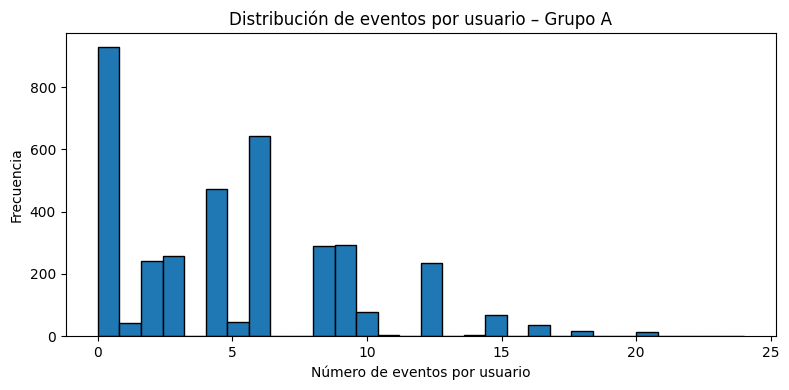

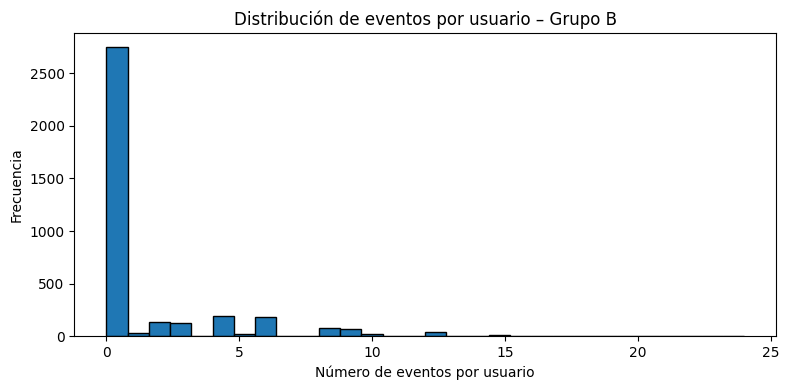


* Primeras filas de eventos por día *
  group        date  events_count
0     A  2020-12-07           331
1     A  2020-12-08           341
2     A  2020-12-09           385
3     A  2020-12-10           350
4     A  2020-12-11           374


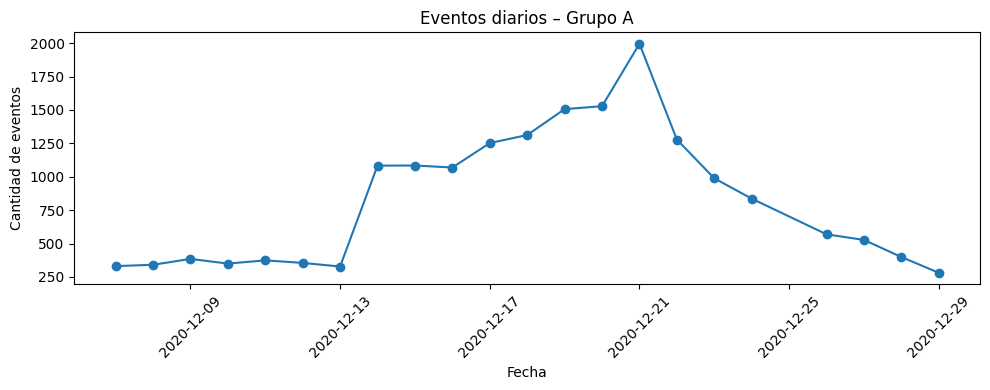

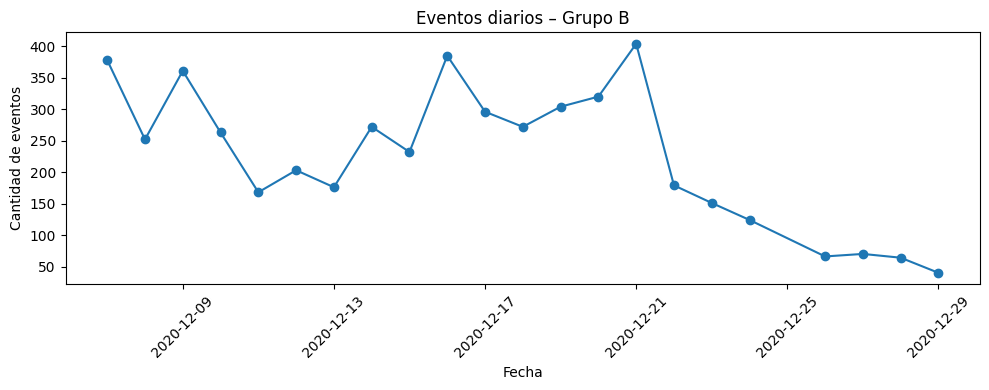

In [50]:

# Distribución de eventos (por usuario y por día)

# Eventos por usuario
ev_per_user = (
    ev.groupby(["group","user_id"])["event_name"]
    .count()
    .reset_index(name="events_count")
)

print("\n* Resumen: número de eventos por usuario *")
print(ev_per_user.groupby("group")["events_count"].describe())

# Estadísticos resumidos 
stats_user = ev_per_user.groupby("group")["events_count"].agg(["mean","median","std","min","max"])
print("\nEstadísticos resumidos por grupo:")
print(stats_user)

# 3) Histogramas de eventos por usuario
for g, dfg in ev_per_user.groupby("group"):
    plt.figure(figsize=(8,4))
    plt.hist(dfg["events_count"], bins=30, edgecolor="black")
    plt.title(f"Distribución de eventos por usuario – Grupo {g}")
    plt.xlabel("Número de eventos por usuario")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

# Eventos por día
ev["date"] = ev["event_dt"].dt.date
ev_per_day = ev.groupby(["group","date"])["event_name"].count().reset_index(name="events_count")

print("\n* Primeras filas de eventos por día *")
print(ev_per_day.head())

# Eventos diarios
for g, dfg in ev_per_day.groupby("group"):
    plt.figure(figsize=(10,4))
    plt.plot(dfg["date"], dfg["events_count"], marker="o")
    plt.title(f"Eventos diarios – Grupo {g}")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad de eventos")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Interpretación

Los usuarios del grupo A registraron en promedio casi 5 eventos por persona, mientras que el grupo B apenas alcanzó 1.3 eventos en promedio.

Además, la mediana del grupo B es 0, lo que indica que más de la mitad de sus usuarios no realizaron ningún evento después de registrarse.

Esto sugiere que el grupo B tuvo una actividad significativamente menor, lo cual podría:

Sesgar las tasas de conversión, ya que una menor interacción implica menos oportunidades de conversión.

Evidenciar un problema técnico o de segmentación, posiblemente relacionado con la activación incorrecta del sistema de recomendaciones en algunos usuarios.

Conclusión preliminar: los grupos no están equilibrados en su nivel de interacción.

Ambos presentan un patrón temporal similar, con actividad estable durante los primeros días y picos a partir del 21 de diciembre.

El grupo A muestra un mayor volumen de actividad y picos más pronunciados, reflejando un nivel de interacción más alto.

Aunque el grupo B también presenta picos, su magnitud es considerablemente menor, confirmando una menor participación a lo largo del experimento.

Los picos del 21 y del 25–31 de diciembre se asocian probablemente con:

El cierre del periodo de incorporación de nuevos usuarios (21 de diciembre).

El inicio de la campaña “Christmas & New Year Promo” (25 de diciembre).

4. EVALUCIÓN DE LOS RESULTADOS DE LA PRUEBA A/B

Hipótesis nula (H₀): No hay diferencia en las proporciones (A = B)

Hipótesis alternativa (H₁): La proporción del grupo B es mayor que la del grupo A (B > A)

In [51]:
ALPHA = 0.05
CORRECTION = "bonferroni" 

# Función para aplicar prueba z por etapa del embudo
def ztest_step(funnel_df, step):
    f = funnel_df.set_index("group")
    count = np.array([f.loc["B", step], f.loc["A", step]])  # éxitos
    nobs  = np.array([f.loc["B","total_users"], f.loc["A","total_users"]])  # totales
    stat, pval = proportions_ztest(count, nobs, alternative="larger")  # H1: B > A
    lift = (count[0]/nobs[0]) / (count[1]/nobs[1]) - 1
    return {
        "metric": step,
        "A_succ": int(count[1]),
        "A_n": int(nobs[1]),
        "B_succ": int(count[0]),
        "B_n": int(nobs[0]),
        "z": stat,
        "p": pval,
        "lift_%": round(lift*100, 2)
    }

# Aplicamos la prueba a cada etapa del embudo
tests = [ztest_step(funnel_df, step) for step in ["product_page","product_cart","purchase"]]
tests_df = pd.DataFrame(tests)

# Corrección por comparaciones múltiples
reject, p_adj, _, _ = multipletests(tests_df["p"], alpha=ALPHA, method=CORRECTION)
tests_df["p_adj"] = p_adj
tests_df["reject_H0"] = reject
tests_df["alpha"] = ALPHA
tests_df["correction"] = CORRECTION

print("\n* Resultados de la prueba z (B > A) con corrección múltiple *")
print(tests_df[["metric","A_succ","A_n","B_succ","B_n","z","p","p_adj","reject_H0","lift_%"]])


* Resultados de la prueba z (B > A) con corrección múltiple *
         metric  A_succ   A_n  B_succ  B_n         z         p  p_adj  \
0  product_page    1780  2747     523  928 -4.595797  0.999998    1.0   
1  product_cart     824  2747     255  928 -1.456161  0.927326    1.0   
2      purchase     872  2747     256  928 -2.374087  0.991204    1.0   

   reject_H0  lift_%  
0      False  -13.03  
1      False   -8.39  
2      False  -13.10  


5. INTERPRETACIÓN Y CONCLUSIONES 

Dirección del efecto

Todos los valores z son negativos, lo que indica que el grupo B presentó tasas de conversión inferiores a las del grupo A.

El lift (diferencia porcentual entre B y A) también es negativo en las tres etapas del embudo:

  > 13 % en product_page
  > 8 % en product_cart
  > 13 % en purchase

Significancia estadística

Los valores p corregidos (p_adj = 1.0, corrección de Bonferroni) son muy superiores a 0.05.

En consecuencia, no se rechaza la hipótesis nula (H₀) en ninguna de las etapas analizadas.

  > Las diferencias observadas no son estadísticamente significativas.

En conclusión, el nuevo sistema de recomendaciones no generó una mejora significativa en ninguna fase del embudo de conversión.
Por el contrario, el grupo B mostró un desempeño inferior al grupo A, aunque las diferencias no alcanzan significancia estadística.

Posibles explicaciones

Actividad desigual:
El grupo B registró una actividad promedio considerablemente menor (1.3 eventos por usuario vs. 4.9 en el grupo A).
Esto sugiere que los usuarios del grupo experimental interactuaron mucho menos con la tienda, afectando así su potencial de conversión.

Sesgo temporal:
Los picos de actividad entre el 21 y el 31 de diciembre coinciden con la campaña “Christmas & New Year Promo”, lo cual pudo influir en el comportamiento de compra y alterar la interpretación del efecto del experimento.

Tamaño muestral:
El grupo B cuenta con casi la mitad de usuarios que el grupo A (928 vs. 2,747), lo que reduce el poder estadístico de las pruebas y limita la capacidad para detectar diferencias significativas.

Posible fallo de implementación:
No se descarta que existiera un problema técnico o de relevancia en el sistema de recomendaciones, ya sea por sugerencias inadecuadas o por errores en el flujo del embudo.
Sin embargo, con la información disponible no es posible confirmar esta hipótesis.

Conclusión general

El nuevo sistema de recomendaciones no generó mejoras en la conversión y, en términos generales, presentó un rendimiento inferior al sistema actual.

Se recomienda no proceder con su implementación por el momento y realizar una nueva prueba que contemple:

Controlar la segmentación de usuarios.

Equilibrar el tamaño de las muestras entre grupos.

Aislar la influencia de campañas externas u otros factores temporales que puedan sesgar los resultados.